<a href="https://colab.research.google.com/github/yashlal/Deepfake-Microbiomes/blob/main/OrdinationPlot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CUDA device selected!
Using 1 GPU


Epoch 0: Loss 0.5789764248835528
Epoch 10: Loss 0.5515250520261199
Epoch 20: Loss 0.5223579269598938
Epoch 30: Loss 0.49070928461269103
Epoch 40: Loss 0.45477285599857253
Epoch 50: Loss 0.4180469649597498
Epoch 60: Loss 0.3784284154654881
Epoch 70: Loss 0.33749635574087095
Epoch 80: Loss 0.2955297527165907
Epoch 90: Loss 0.25297345531587695
Epoch 100: Loss 0.21282921307208272
Epoch 110: Loss 0.17515134375171137
Epoch 120: Loss 0.14190651849539548
Epoch 130: Loss 0.11423054442537381
Epoch 140: Loss 0.08741519830129832
Epoch 150: Loss 0.06679025343516527
Epoch 160: Loss 0.0496403548576216
Epoch 170: Loss 0.039601173223673077
Epoch 180: Loss 0.02946320646632693
Epoch 190: Loss 0.020649848579943234
Epoch 200: Loss 0.014380444037311013
Epoch 210: Loss 0.010539092491206051
Epoch 220: Loss 0.0078556555237486
Epoch 230: Loss 0.006517954936645177
Epoch 240: Loss 0.004270286956184792
Epoch 250: Loss 0.0043519491465200295
Epoch 260: Loss 0.002696935987276288
Epoch 270: Loss 0.005112207188504444
E

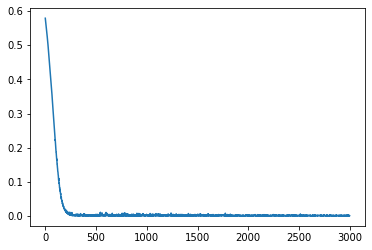

In [11]:
from newsolver import predict_community_fullnp
import numpy as np
import pandas as pd
import random as rd
from numba import njit
from numba.typed import List
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import time
from math import sqrt
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from modules import regenerate_PWMatrix, genrand
from scipy.stats import wasserstein_distance as WD

data = pd.read_excel('RealData.xlsx', index_col=0)
specs = data.columns.tolist()
trimmed_specs = []
typed_trimmed_specs = List()
prob_distro = {}

for i in range(len(specs)):
    if data.iloc[:,i].astype(bool).sum() >= 85:
        trimmed_specs.append(specs[i])
        prob_distro[specs[i]] = data.iloc[:,i].astype(bool).sum() / (462)
        typed_trimmed_specs.append(specs[i])

@njit()
def get_LT(full_ar):
    ar = []
    for i in range(len(full_ar)):
        for j in range(i):
            ar.append(full_ar[i][j])
    return ar

@njit()
def generate_matrix(comm):
    dim = len(comm)
    ar = np.zeros((dim,dim))

    for i in range(dim):
        for j in range(i+1):
            if i == j:
                ar[i][j] = 0
            else:
                r = rd.random()
                ar[i][j] = r
                ar[j][i] = 1-r

    return ar

# select CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == 'cuda:0':
    print('CUDA device selected!')
elif str(device) == 'cpu':
	print('CUDA device not available. CPU selected')

class MyNet(nn.Module):
    def __init__(self, hyperparam):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(462, hyperparam)
        self.fc2 = nn.Linear(hyperparam, 231*461)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def test_net(model, test_size, Lambda_Mat, prob_distro):
    for epoch in range(test_size):
        npcm = np.zeros(462)
        subset = []
        for sp in trimmed_specs:
            bin = genrand(prob_distro[sp])
            if bin:
                subset.append(sp)
        subset_lam = (Lambda_Mat.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)
        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]

        input = torch.from_numpy(npcm).float().to(device)
        true_y = torch.FloatTensor(get_LT(Lambda_Mat.to_numpy())).to(device)
        output = model(input).to(device)
        loss1 = criterion(output, true_y)
        s = sqrt(loss1.item()/(231*461))
        lam_pred = (pd.DataFrame(regenerate_PWMatrix(output.tolist(), 462), index=trimmed_specs, columns=trimmed_specs).loc[subset, subset]).to_numpy()
        cm_pred = predict_community_fullnp(lam_pred, subset, verb=False)
        loss2 = WD(cm, cm_pred)
        print(f'Testing Epoch {epoch}')
        print(f'Lambda Loss is {s}')
        print(f'Community Loss is {loss2}')

def train_net(model, train_size):
    full_m = pd.DataFrame(generate_matrix(typed_trimmed_specs), index=trimmed_specs, columns=trimmed_specs)
    train_y = get_LT(full_m.to_numpy())
    loss_values = []
    pbar2=tqdm(range(train_size))
    pbar2.set_description('Training Neural Net')
    for epoch in pbar2:

        npcm = np.zeros(len(trimmed_specs))
        size = rd.randint(25, 235)
        subset = rd.sample(trimmed_specs, size)
        subset_lam = (full_m.loc[subset, subset]).to_numpy()
        cm = predict_community_fullnp(subset_lam, subset, verb=False)

        for i in range(len(cm)):
            npcm[trimmed_specs.index(subset[i])] = cm[i]


        optimizer.zero_grad()

        x, y = npcm, train_y

        input = torch.from_numpy(x).float().to(device)
        true_y = torch.FloatTensor(y).to(device)
        output = model(input).to(device)
        loss = criterion(output, true_y).to(device)
        s = sqrt(loss.item()/(231*461))
        if (epoch % 10)==0:
          print(f'Epoch {epoch}: Loss {s}')
        loss_values.append(s)
        loss.backward()
        optimizer.step()

    return loss_values, train_y

if __name__=='__main__':
    train_size, test_size, param = 3000, 25, 2500
    path = 'model.pth'

    net = MyNet(param).to(device)

    #Multi GPU Support
    if torch.cuda.device_count() > 1:
          print(f'Using {torch.cuda.device_count()} GPUs')
          net = nn.DataParallel(net)
    elif torch.cuda.device_count() == 1:
        print(f'Using {torch.cuda.device_count()} GPU')

    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    lv, full_lam = train_net(net, train_size=train_size)
    full_lam = pd.DataFrame(np.array(regenerate_PWMatrix(full_lam, 462)), index=trimmed_specs, columns=trimmed_specs)
    test_net(model=net, test_size=test_size, Lambda_Mat=full_lam, prob_distro=prob_distro)
    torch.save(net.state_dict(), path)
    plt.plot(lv)
    plt.savefig('Loss')
    plt.show()
